In [1]:
import numpy as np
from yaml import safe_load
import json
from astropy.time import Time
from astropy import units as u
from astropy.coordinates import ICRS, get_sun, Longitude
from sunpy.coordinates.frames import Helioprojective

from helioschedule.get_local_noons import SolarTransiter
from helioschedule.schedule import DayScheduler

from matplotlib import pyplot as plt

In [2]:
SIDEREAL_FACTOR = 1.0027379093604878  # 86400/((1.0*units.sday).to(units.s).value)

In [3]:
conf = safe_load(open("John_MWA_Dwell_solo_2024.yaml"))
azel = {int(k): v for k, v in json.load(open(conf["files"]["pointings"])).items()}
print(conf['priority'])
print(conf['solarOffset'])

['East']
10800


### Calculate local noons closest to reference time

In [4]:
# The following class abstracts dealing with skyfield
transiter = SolarTransiter(lat_deg_n=conf["lat"],
                            lon_deg_e=conf["lon"],
                            elevation_m=conf["alt"])

local_noons = []
for i in range(5, 9):
    ref_time = Time(conf['refDate'])+i*u.day

    # Calculate the local noon closest to (within +/- 12 hours of) ref_time
    # NB still need to supply times  in skyfield type, but SolarTransiter
    # has an attribute to make this easy.
    local_noon = transiter.get_transit(transiter.ts.from_astropy(ref_time-12*u.hour),
                                    transiter.ts.from_astropy(ref_time+12*u.hour)).to_astropy().utc[0]
    print(local_noon.isot, int(local_noon.gps))
    local_noons.append(local_noon)
                                    
n = len(local_noons)

2024-10-06T04:01:22.462 1412222500
2024-10-07T04:01:05.156 1412308883
2024-10-08T04:00:48.255 1412395266
2024-10-09T04:00:31.777 1412481649


### Get Sun coordinates and calculate HA and Decl. of fields based on location of Sun at reference time.

For scheduling purposes, the coordinates required for each target are the Hour Angle *relative to the Sun* and the Declination, both in Degrees.

Note that the code in `convert_coordinates.py` which does this is not particularly accurate or fast (in part because it dates from before `sunpy` was mature). But it is good enough to make updating it a low priority. 

Here we can use `sunpy` for much more readable code.  Note that `Tx` is west positive, whereas for the yaml file, we measure position angle as North through East.

In [5]:
suns = [get_sun(t) for t in local_noons]
assert len(conf['priority'])==1, f"Only expecting one field to schedule, got {len(conf['priority'])}"
c = conf['priority'][0]
has = []
decs = []
for i in range(n):
    hpc = Helioprojective(Tx=-conf['fields'][c]['coordinates'][0]*u.deg*np.sin(np.radians(conf['fields'][c]['coordinates'][1])),
                            Ty=conf['fields'][c]['coordinates'][0]*u.deg*np.cos(np.radians(conf['fields'][c]['coordinates'][1])),
                            distance=1*u.Mpc,
                            obstime = local_noons[i],
                            observer='earth')
    radec = hpc.transform_to(ICRS())
    has.append(Longitude(radec.ra - suns[i].ra, wrap_angle=180 * u.deg))
    decs.append(radec.dec)
print(has)
print(decs)

[<Longitude 28.02866661 deg>, <Longitude 28.0808006 deg>, <Longitude 28.13540679 deg>, <Longitude 28.19245025 deg>]
[<Latitude -17.33489987 deg>, <Latitude -17.68494142 deg>, <Latitude -18.03038039 deg>, <Latitude -18.37108975 deg>]


### Set up Scheduler object and schedule

In [6]:
schedulers = []
for i in range(n):
    schedulers.append(DayScheduler(conf=conf))
    schedulers[i].setup_day(ref_time_gps=local_noons[i].gps + has[i].hour*3600 - 1300)
    schedulers[i].setup_obs(solar_noon_gps=local_noons[i].gps, ha=has[i].deg, dec=decs[i].deg, dec_sun=suns[i].dec.deg, beam_chan=conf['fields'][c]['beam_chan'])

In [7]:
def mode(a):
    _, idx, counts = np.unique(a, return_index=True, return_counts=True)
    return a[idx[np.argmax(counts)]]

In [8]:
duration=200
obs_chan="57:68;121:132"
obs_name_prefix='waszewski2024a_ddt_ips'
field=""
shifttime=200
inttime=0.5
freqres=40
creator="jmorgan"
project="G0106"


2024-10-06T04:01:22.462
2700 slots
14 unique pointings
13 changes of pointing
change_indices [   0  159  273  468  713  928 1138 1345 1563 1801 2083 2098 2409 2447]
[159 114 195 245 215 210 207 218 238 282  15 311  38 253]
[1272  912 1560 1960 1720 1680 1656 1744 1904 2256  120 2488  304 2024]
1 observations of length 120
1 observations of length 304
1 observations of length 912
1 observations of length 1272
1 observations of length 1560
1 observations of length 1656
1 observations of length 1680
1 observations of length 1720
1 observations of length 1744
1 observations of length 1904
1 observations of length 1960
1 observations of length 2256
1 observations of length 2488
(108, 25)
96/108 observations have the same optimal pointing for all 25 8-second blocks
2024-10-07T04:01:05.156
2700 slots
15 unique pointings
14 changes of pointing
change_indices [   0  155  296  469  703  918 1128 1337 1556 1795 1798 2078 2100 2413
 2447]
[155 141 173 234 215 210 209 219 239   3 280  22 313  34 25

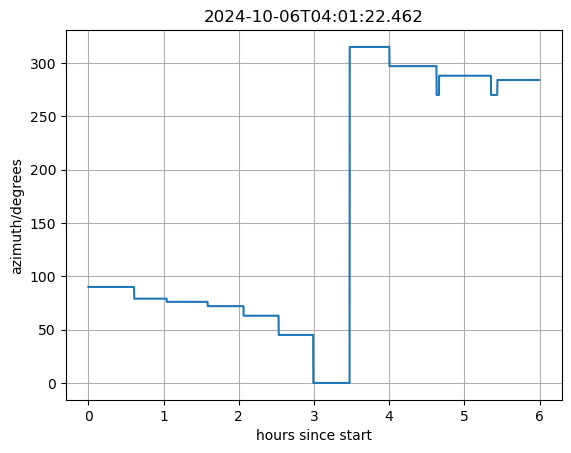

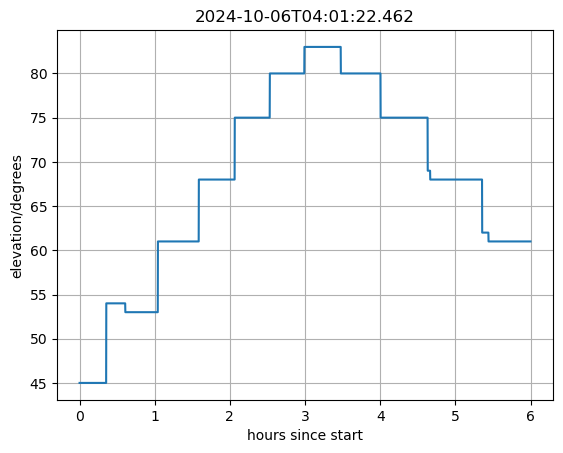

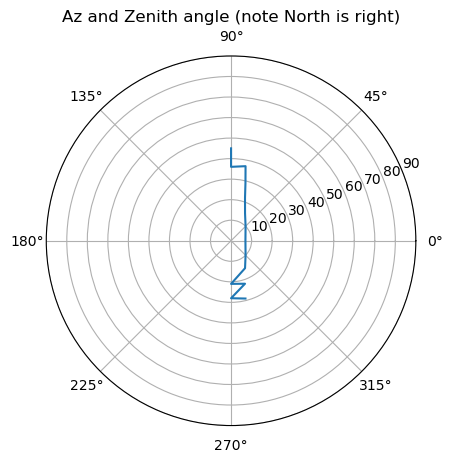

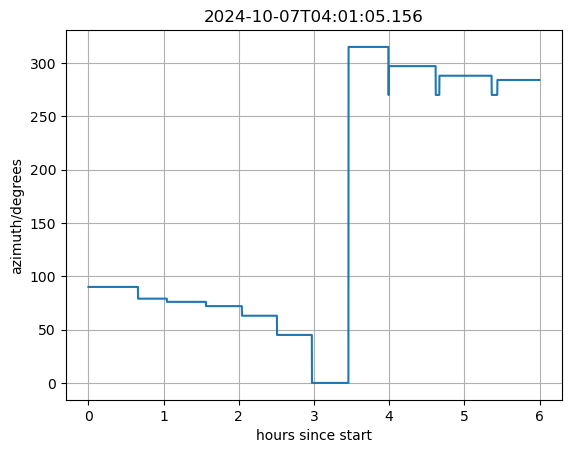

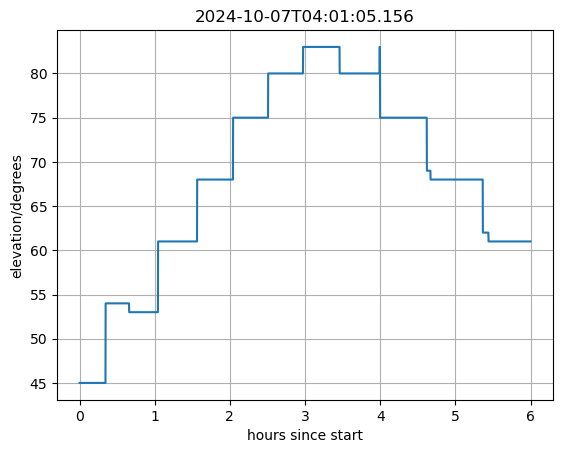

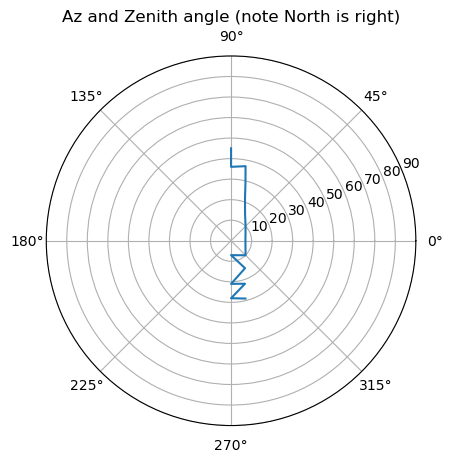

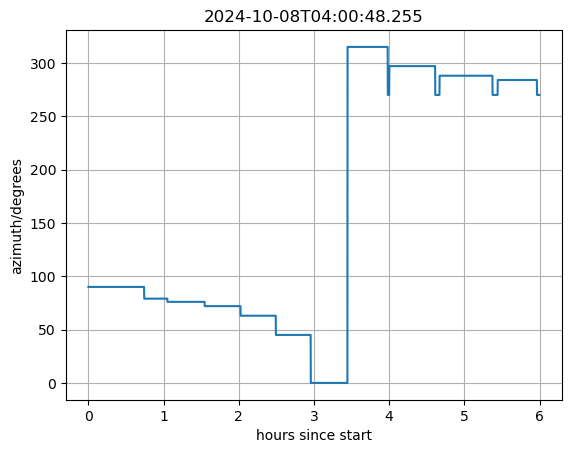

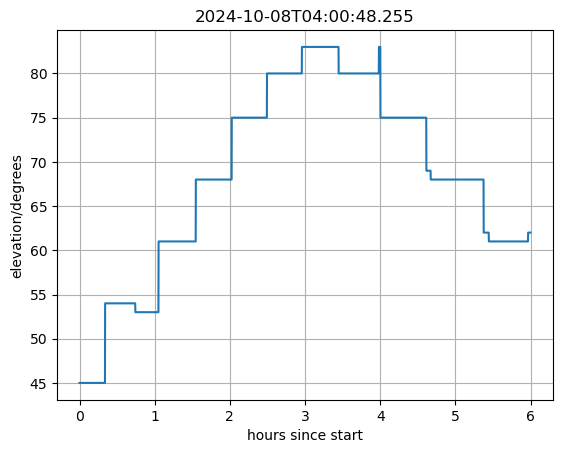

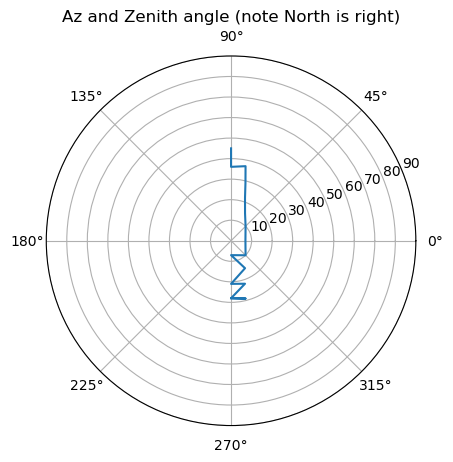

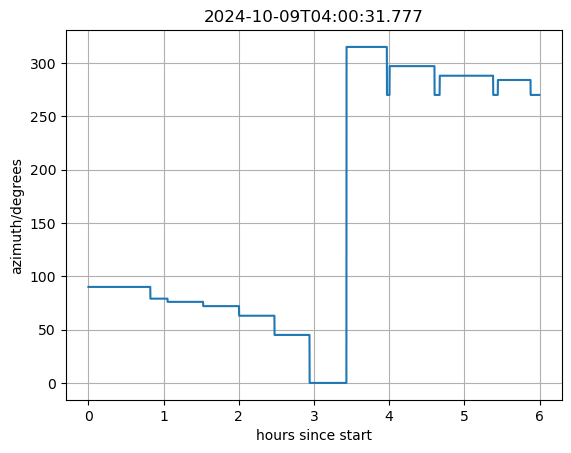

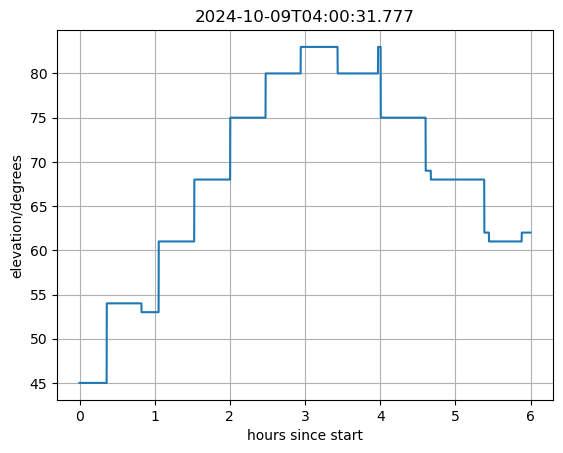

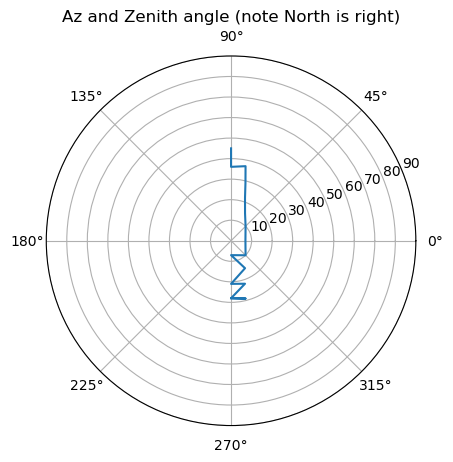

In [9]:
f_sh = open("waszewski_ddt_2024Oct.sh", 'w')
f_csv = open("waszewski_ddt_2024Oct.csv", 'w')
for i in range(n):
    all_obstimes = schedulers[i].all_obstimes
    target_beam = schedulers[i].target_beam
    sun_beam = schedulers[i].sun_beam
    sun_filter = schedulers[i].sun_filter

    # sun_filter=True means good
    idxs = np.nanargmax(np.where(sun_filter, target_beam, np.nan), axis=0)
    az = np.array([azel[i][0] for i in idxs])
    el = np.array([azel[i][1] for i in idxs])

    plt.figure()
    plt.plot(np.arange(len(az))*8/3600., az)
    plt.xlabel("hours since start")
    plt.ylabel("azimuth/degrees")
    plt.grid()
    plt.title(f"{local_noons[i].utc.isot}")
    plt.figure()
    plt.plot(np.arange(len(az))*8/3600., el)
    plt.xlabel("hours since start")
    plt.ylabel("elevation/degrees")
    plt.grid()
    plt.title(f"{local_noons[i].utc.isot}")
    fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
    ax.plot(np.radians(az), 90-el)
    ax.set_rmax(90)
    ax.set_title("Az and Zenith angle (note North is right)")
    print(local_noons[i].utc.isot)

    print(f"{len(idxs)} slots")
    print(f"{len(np.unique(idxs))} unique pointings")
    print(np.sum(np.diff(idxs) != 0), "changes of pointing")

    change_idxs = np.hstack(([0], np.where(np.diff(idxs) != 0)[0]))
    print("change_indices", change_idxs)
    obs_lengths = np.diff(np.hstack((change_idxs, len(idxs))))
    print(obs_lengths)
    print(obs_lengths*8)
    for j in sorted(np.unique(np.diff(change_idxs))):
        print(f"{np.sum(np.diff(change_idxs)==j)} observations of length {j*8}")

    idxs_200 = idxs.reshape(-1, 25)
    sb_200 = sun_beam.reshape(197, -1, 25)
    tb_200 = target_beam.reshape(197, -1, 25)
    print(idxs_200.shape)
    n_obs_200 = idxs_200.shape[0]
    print(f"{np.sum(np.all(idxs_200==idxs_200[:, 0, None], axis=1))}/{n_obs_200} observations have the same optimal pointing for all 25 8-second blocks")


    times = Time(all_obstimes[::25], format='gps')


    for j in range(n_obs_200):
        sweetspot=mode(idxs_200[j])
        az = azel[sweetspot][0]
        el = azel[sweetspot][1]
        time_comma = times[j].utc.isot[:19].replace("T", ",")
        obsid = str(int(times[j].gps))
        OBSERVATION_STR = f"schedule_observation.py --starttime={time_comma} --stoptime=++{duration}s --freq='{obs_chan}' --obsname={obs_name_prefix}{field} --shifttime={shifttime} --mode=MWAX_CORRELATOR --inttime={inttime} --freqres={freqres} --creator={creator} --project={project} --azimuth={az} --elevation={el} # {obsid}"
        print(OBSERVATION_STR, file=f_sh)

    for j in range(n_obs_200):
        sweetspot=mode(idxs_200[j])
        az = azel[sweetspot][0]
        el = azel[sweetspot][1]
        time = times[j].utc.isot[:19]
        obsid = str(int(times[j].gps))
        target_beam = tb_200[sweetspot, j, 12]
        sun_beam = sb_200[sweetspot, j, 12]
        print(','.join((obsid,time,str(sweetspot),str(az),str(el),f"{target_beam:.6e}",f"{sun_beam:.6e}")), file=f_csv)
f_sh.close()
f_csv.close()